# Alternative Embeddings

In this notebook, we document several variations of the persistent homology point group identification algorithm that we experiemented with to try to fix some of the shortcomings. None of these seemed to solve our problems.

## Effects of Blurring Images

See how blurring the image effects the persistent homology of $E(2)/\Gamma$ for images that previously are very noisy and have a weak signal. Blurring an image gives pixels information from their neighbors. For instance, given an all black area next to an all white area, black pixels near the border look the same as pixels in the center. However, after blurring, the pixels closer to the border are lighter, and thus carry more "information" about the overall image they exist in.

In [1]:
# importing packages
from ripser import ripser
from persim import plot_diagrams
from numpy import pi,sin,cos
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
from math import dist
from math import sqrt
from math import ceil, exp
from PIL import Image
from PIL import ImageFilter
from IPython.display import display
import glob
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances

In [2]:
# FUNCTIONS

# Given an image, a lens size, and a translation, this translation_snapshot() 
# returns a snapshot after the translation is performed.
def translation_snapshot(img, lens_sz, translation):
    (a,b) = translation 
    translation = (-a,-b)
    (x,y) = upper_left_center(img, translation)
    (length, height) = img.size
    
    lens_corner_x = x - lens_sz/2.0 
    lens_corner_y = y - lens_sz/2.0 
    ret_img = img.crop((lens_corner_x,lens_corner_y, lens_corner_x+lens_sz, lens_corner_y+lens_sz))
    
    #make sure didn't fall off of the image
    (ret_length, ret_height) = ret_img.size
    if (lens_corner_x<0 or lens_corner_y<0 or lens_corner_x+lens_sz>length or lens_corner_y+lens_sz>height):
        print("I came off the page!")
        return False
    return ret_img



# Given a point with the origin at the center of the image, upper_left_center()
# returns the same point but with coordinates with an origin at the top left corner. 
# This is a helper function for translation_snapshot().
def upper_left_center(img, center):
    (x,y) = center
    (l, h) = img.size
    return (l/2.0+x , h/2.0 - y) 



# Given an image, a lens size, and an isometry, create_snapshot() performs the 
# isometry on the image and returns a lens size view of the image
def create_snapshot(img, lens_sz, isometry):
    (x,y,rotation) = isometry
    translation = (x,y)
    # turn from radian to degree
    rotation = 57.2958*rotation
    rot_img = img.rotate(rotation)
    return translation_snapshot(rot_img, lens_sz, translation)



# get_pixel_isom() converts a list of isometries into a list of the associated 
# pixel vector embeddings
def get_pixel_isom(isoms, img, lens):
    isom_images = []
    for iso in isoms:
        isom_images.append(create_snapshot(img, lens, iso))
    ret_lst = []
    for elem in isom_images:
        arr = np.asarray(elem)
        arr = arr.reshape(-1)
        ret_lst.append(arr)
    ret_lst = np.asarray(ret_lst)
    return ret_lst



# generate a list of random isometries such that the lens does not fall off of the page
def generate_isoms(img, lens_sz, n_samples):
    lens_range = ((min(img.size)/sqrt(2))-lens_sz)/2.0
    x_trans = (lens_range*2*np.random.random(n_samples) - lens_range)
    y_trans = (lens_range*2*np.random.random(n_samples) - lens_range)
    rotations = (2*pi*np.random.random(n_samples))
    isoms = []
    for i in range(n_samples):
        isoms.append((x_trans[i], y_trans[i], rotations[i]))
    return isoms



# generate a persistent homology graph with ripser and show the H1 intervals
def persistent_homology(img, lens_sz, n_samples, c):
    isoms = generate_isoms(img, lens_sz, n_samples)
    data = get_pixel_isom(isoms, img, lens_sz)
    
    # make persistent homology plot with ripser
    res = ripser(data, maxdim=1,  coeff =c)
    dgms = res['dgms']
    plt.figure(figsize = (4,4)) 
    plt.title("$\mathbb{Z} /$"+str(c)+"$\mathbb{Z}$")
    plot_diagrams(dgms)

    # see how many points are persisting
    H1 = res['dgms'][1].tolist() # all intervals in H1
    d = []
    for pair in H1: 
        d.append(pair[1] - pair[0]) # finding lengths of intervals in H1
    d.sort(reverse = True) # sorting from longest to shortest intervals
    print("largest 7 lengths of H1 intervals")
    print(d[:7])
    

### Point Group $C_4$

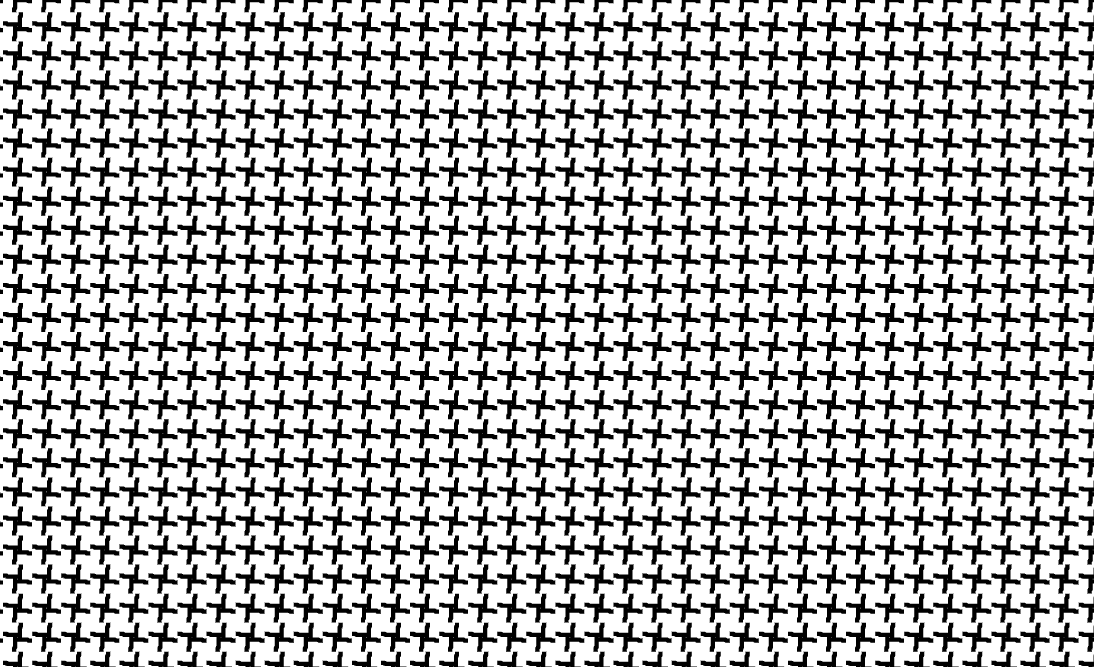

In [3]:
# Grab image from files
img_names = glob.glob('images/*C4pinwheel.png')
img = Image.open(img_names[0])
img = img.convert('L')
display(img)

Without any blurring, this is lense size 40 in coefficient 2 and 3

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[1636.588134765625, 1453.820556640625, 1353.66845703125, 1350.873779296875, 1334.41259765625, 1319.43701171875, 1316.401611328125]


/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[1435.0302734375, 1382.61181640625, 1296.2509765625, 1269.734375, 1239.56787109375, 1237.65625, 1221.0625]


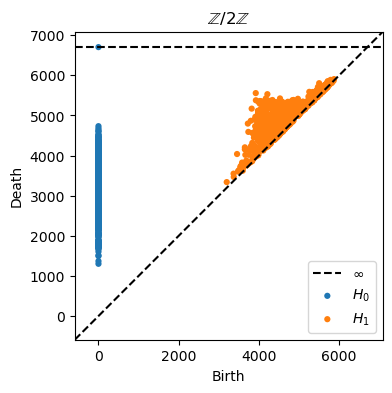

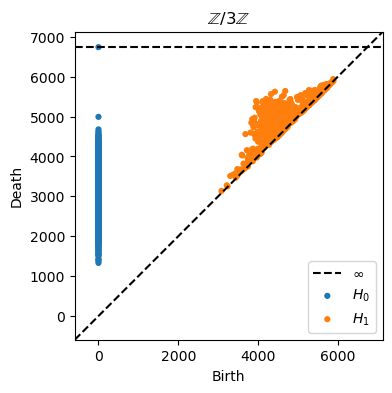

In [4]:
persistent_homology(img, 40, 1000, 2)
persistent_homology(img, 40, 1000, 3)

Looks like just noise. Blur the image and then try the same homology set up:

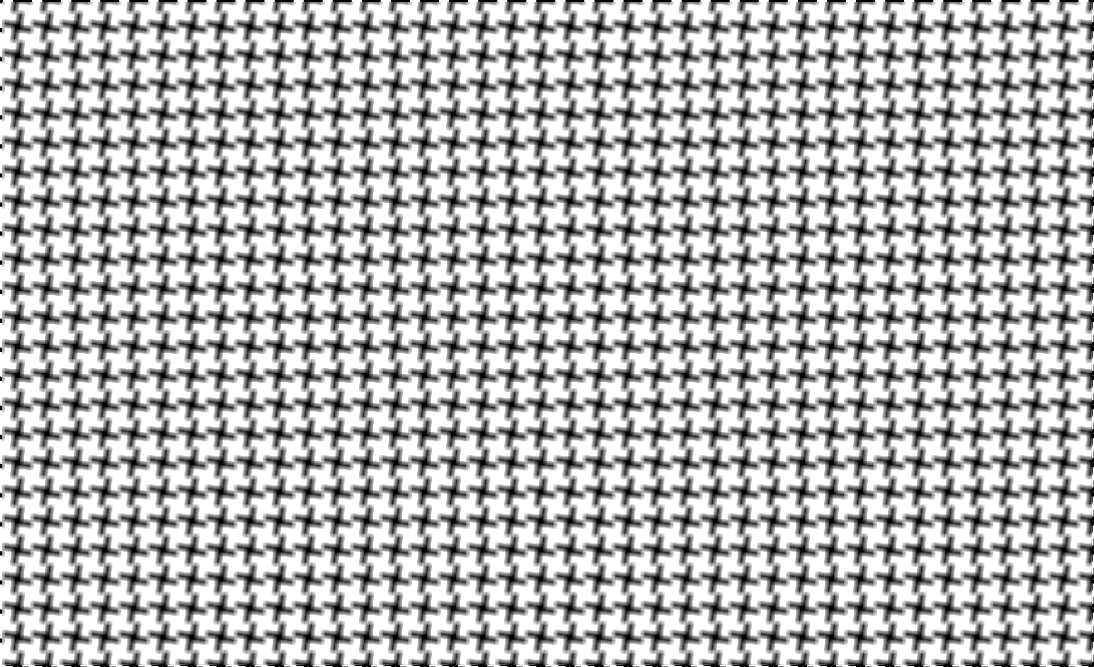

In [5]:
blurred_image = img.filter(ImageFilter.BLUR)
display(blurred_image)

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[1792.5035400390625, 1560.5738525390625, 1128.8570556640625, 1121.270751953125, 1098.546875, 1079.73291015625, 1074.548095703125]


/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[1624.1898193359375, 1242.4407958984375, 1195.1429443359375, 1177.5728759765625, 1147.377685546875, 1124.74609375, 1116.110595703125]


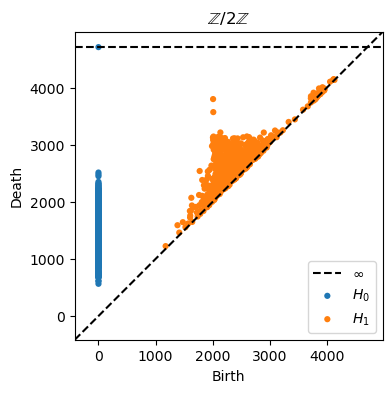

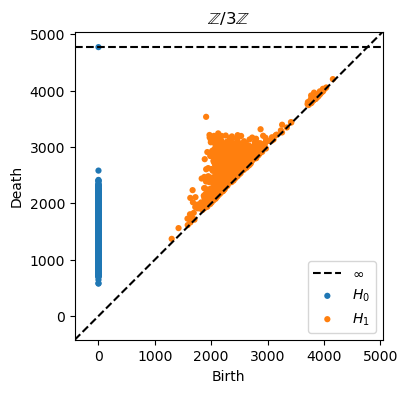

In [6]:
persistent_homology(blurred_image, 40, 1000, 2)
persistent_homology(blurred_image, 40, 1000, 3)

Now these results indicate that there are two $H_1$ homology classes over $Z_2$ and one over $Z_3$, which is what we expect for $C_4$!

### Point Group $C_6$

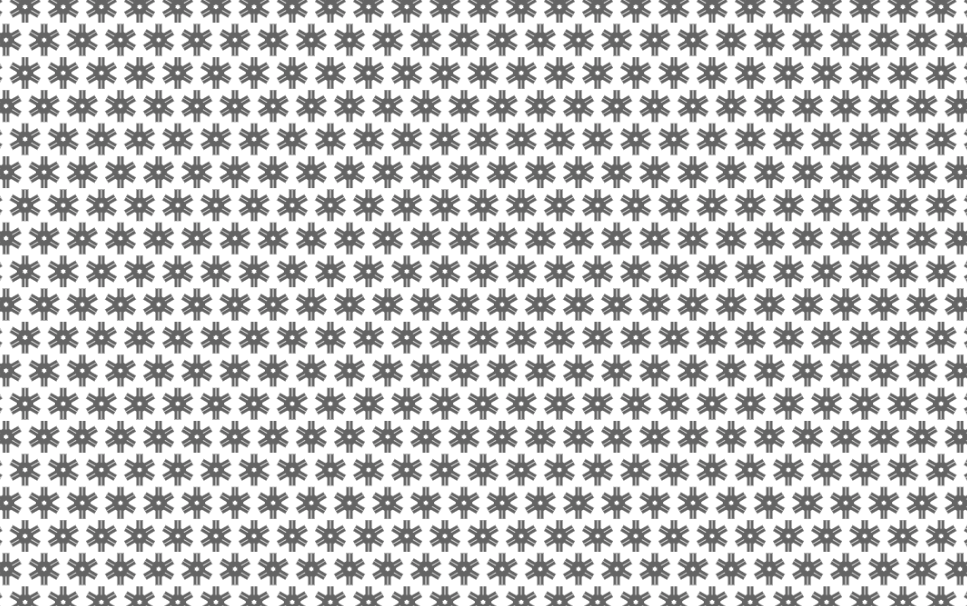

In [7]:
# Grab image from files
img_names = glob.glob('images/*C6 star.png')
img = Image.open(img_names[0])
display(img)

Without any blurring with lens size 100:

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[4778.3916015625, 2968.8134765625, 2959.8056640625, 2789.087890625, 2726.595703125, 2698.6279296875, 2692.193359375]


/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[4888.52734375, 2858.60546875, 2816.5, 2764.16015625, 2667.556640625, 2618.5107421875, 2587.712890625]


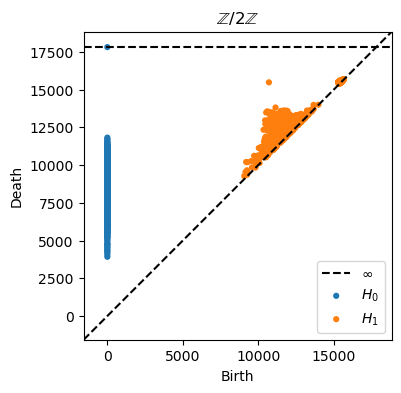

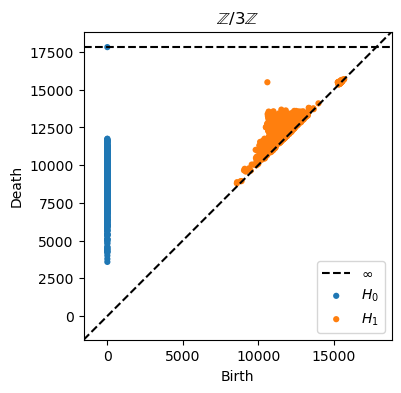

In [8]:
persistent_homology(img, 100, 1000, 2)
persistent_homology(img, 100, 1000, 3)

These results indicate what we expect for $C_6$, but the signal is weak. Now trying the blurred image:

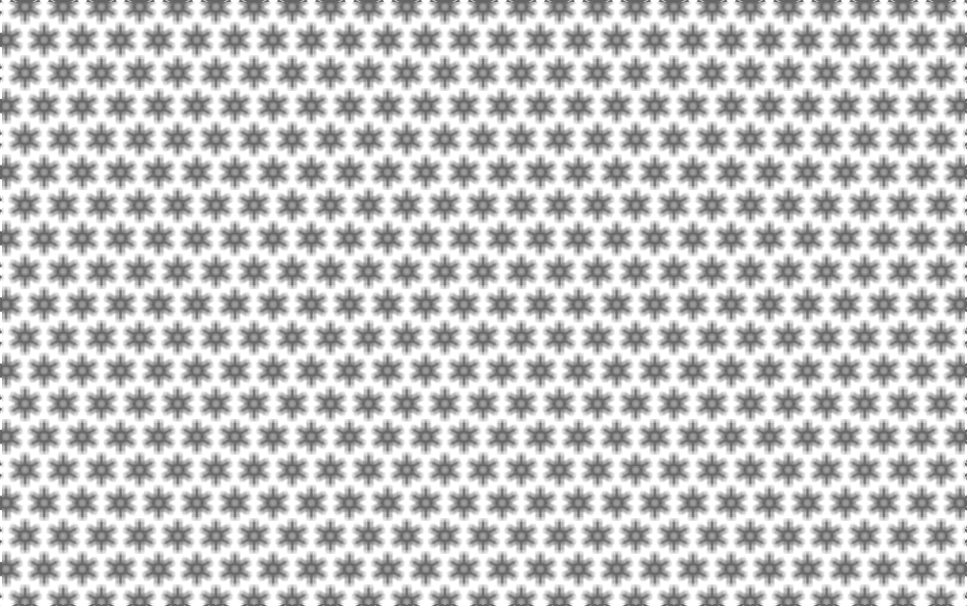

In [9]:
blurred_image = img.filter(ImageFilter.BLUR)
display(blurred_image)

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[5980.2646484375, 3309.20361328125, 3143.92529296875, 3046.04638671875, 2994.5458984375, 2989.17626953125, 2869.6455078125]


/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[5950.79150390625, 3637.48828125, 3345.42333984375, 3094.0400390625, 3065.54931640625, 3041.37744140625, 3016.2568359375]


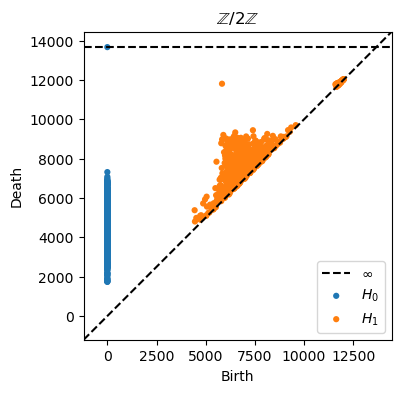

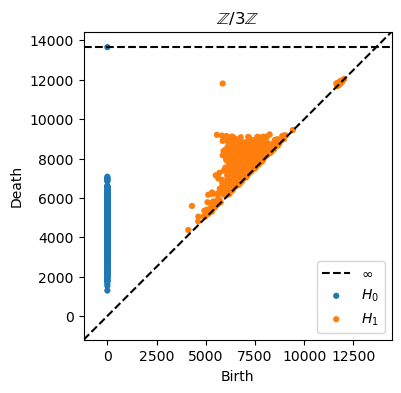

In [10]:
persistent_homology(blurred_image, 100, 1000, 2)
persistent_homology(blurred_image, 100, 1000, 3)

The blurring made the signal much clearer, as the persisting point is much farther from the noise.

Unfortunately blurring does not do much for the other groups.

### Point Group $C_3$

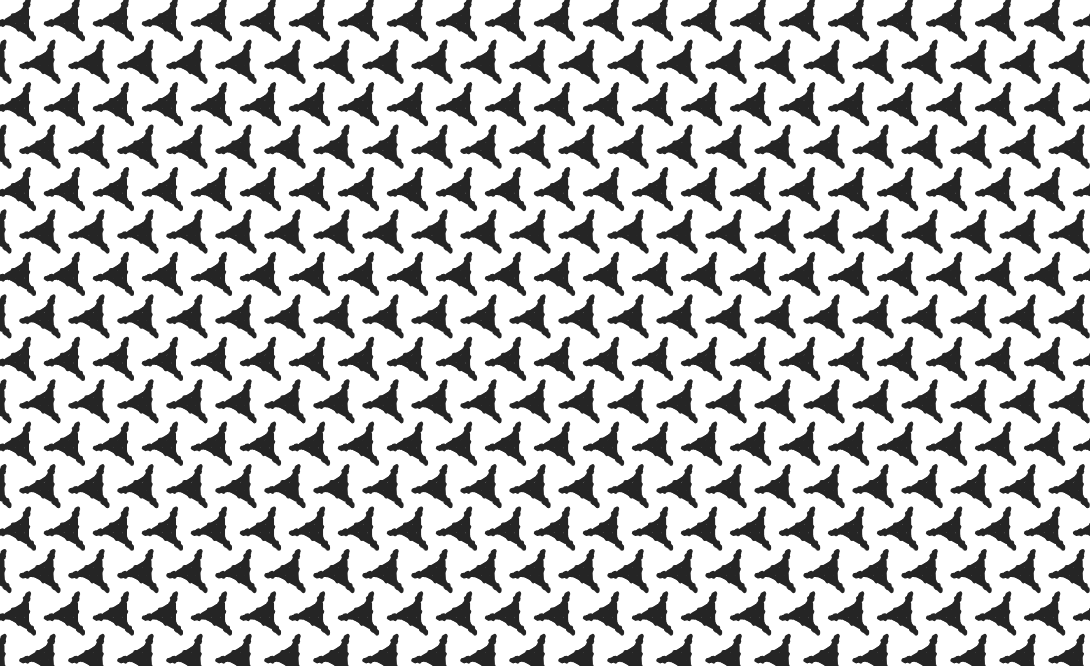

In [11]:
# Grab image from files
img_names = glob.glob('images/*C3 triangles.png')
img = Image.open(img_names[0])
display(img)

Without any blurring:

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[6413.904296875, 6304.208984375, 6284.33984375, 6157.732421875, 6043.9140625, 5931.96484375, 5922.3359375]


/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[8666.923828125, 6390.623046875, 6040.712890625, 5906.947265625, 5843.513671875, 5813.46484375, 5808.84375]


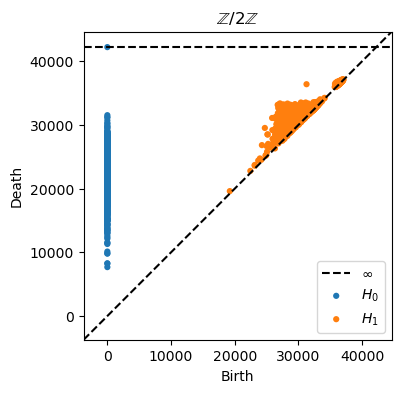

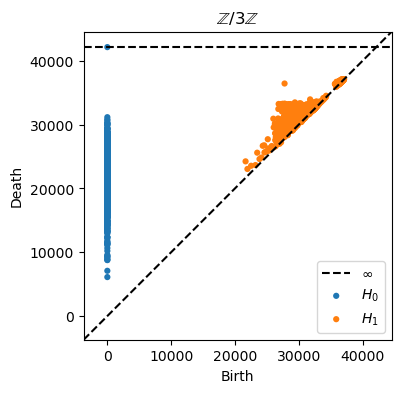

In [12]:
persistent_homology(img, 160, 1000, 2)
persistent_homology(img, 160, 1000, 3)

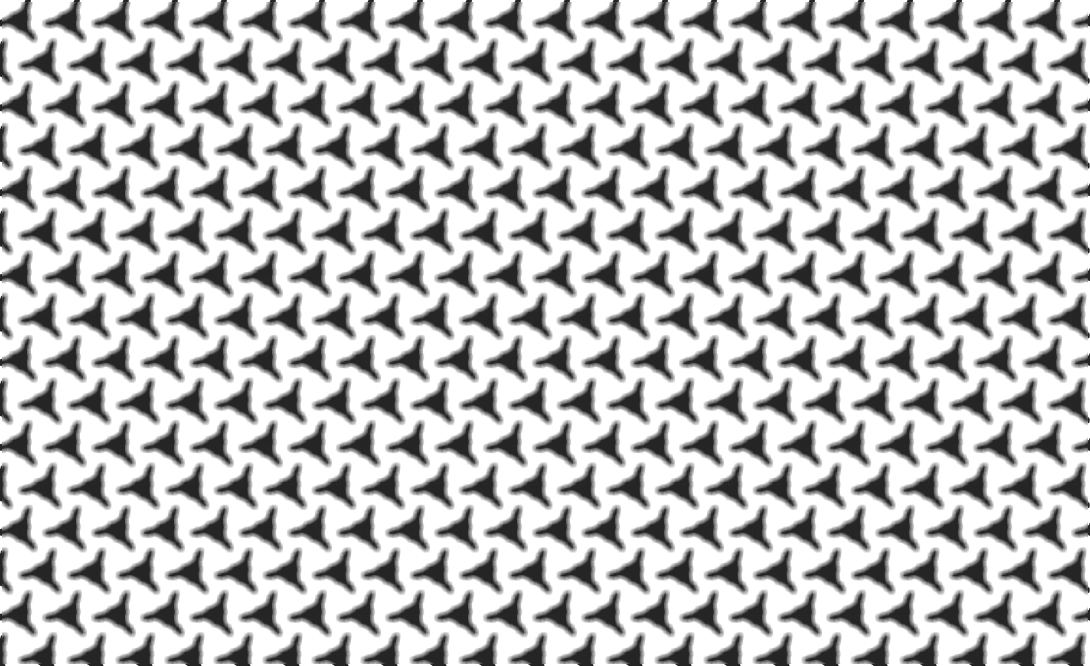

In [13]:
blurred_image = img.filter(ImageFilter.BLUR)
display(blurred_image)

Now the blurred results:

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[8122.521484375, 7174.255859375, 6886.369140625, 6858.71875, 6731.4609375, 6544.81640625, 6493.322265625]


/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[10148.54296875, 7211.943359375, 6964.037109375, 6936.130859375, 6744.802734375, 6635.576171875, 6478.953125]


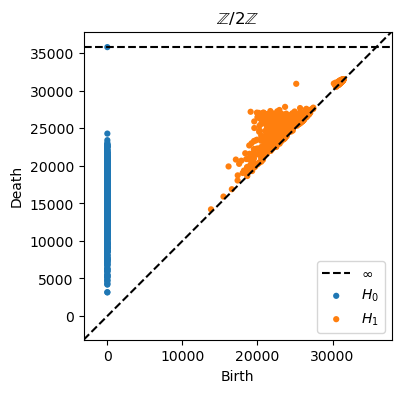

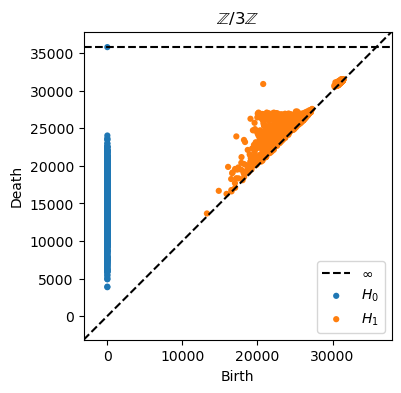

In [14]:
persistent_homology(blurred_image, 160, 1000, 2)
persistent_homology(blurred_image, 160, 1000, 3)

Now we get a more clear signal, but it is the one that we would expect for $C_6$.

### Point Group: $C_2$

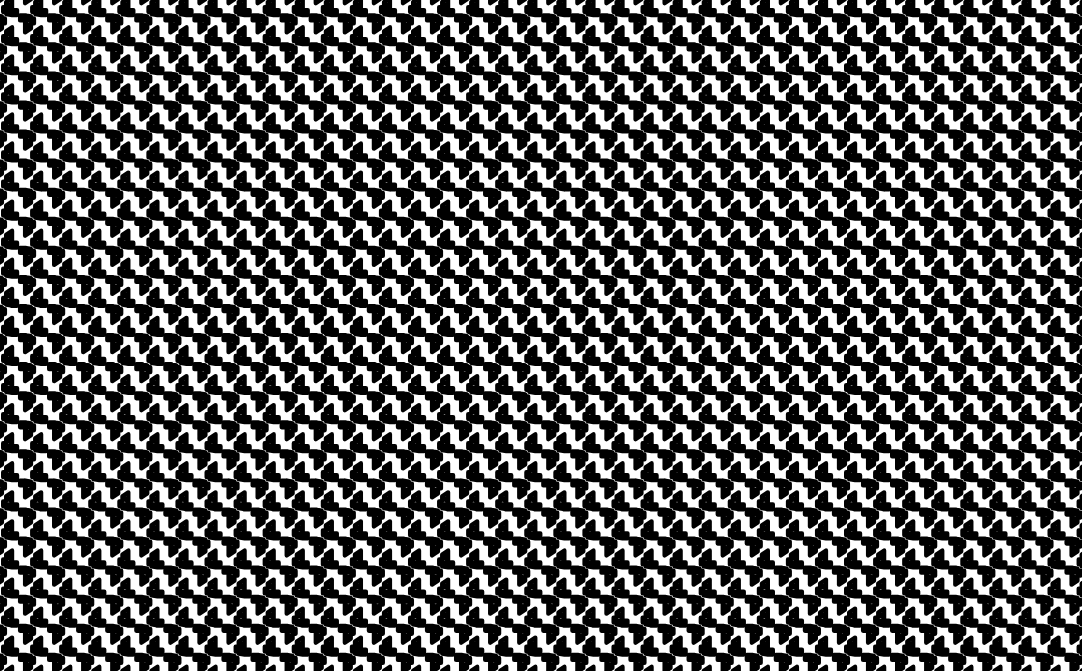

In [15]:
# Grab image from files
img_names = glob.glob('images/*C2bow.png')
img = Image.open(img_names[0])
display(img)

Without blurring:

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[2900.62890625, 2745.853515625, 2594.3095703125, 2559.9697265625, 2537.0126953125, 2500.36328125, 2471.33984375]


/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[3075.587890625, 2738.376953125, 2641.8212890625, 2563.580078125, 2507.5712890625, 2476.1103515625, 2411.33984375]


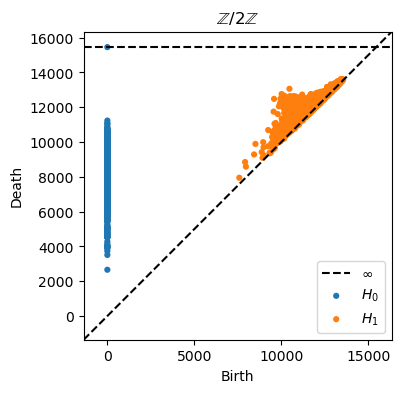

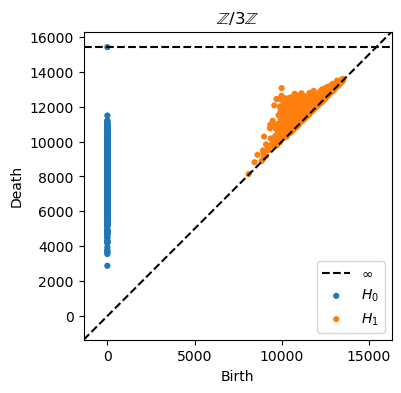

In [16]:
persistent_homology(img, 50, 1000, 2)
persistent_homology(img, 50, 1000, 3)

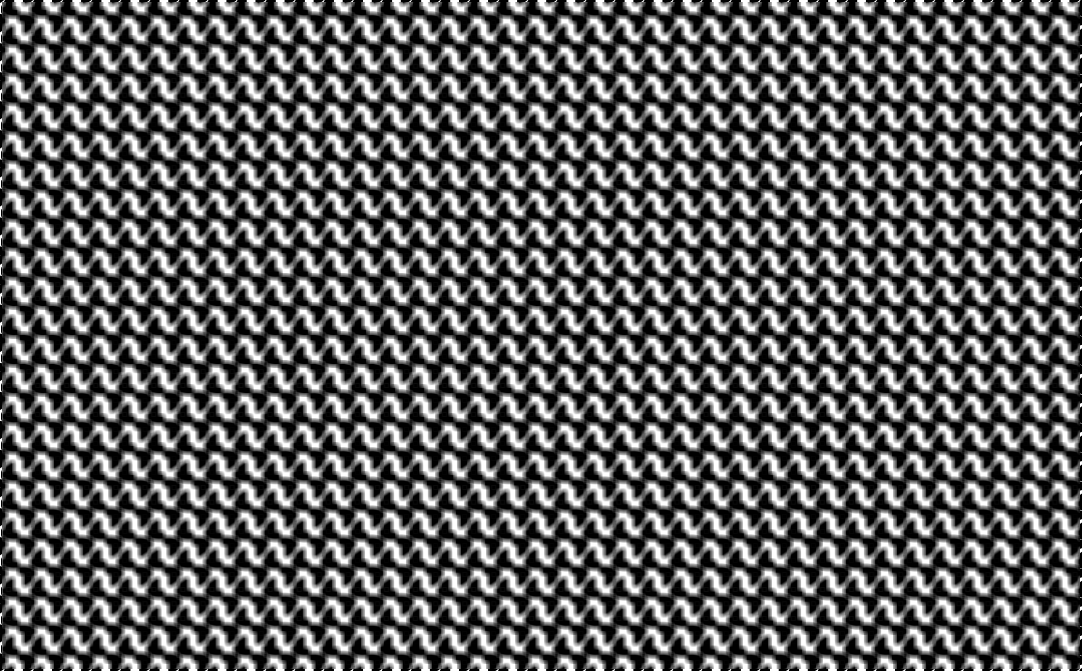

In [17]:
blurred_image = img.filter(ImageFilter.BLUR)
display(blurred_image)

Now with blurring:

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[3027.50244140625, 3009.21875, 2984.8857421875, 2923.59130859375, 2838.1953125, 2836.78125, 2809.60205078125]


/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[3530.96533203125, 3307.197265625, 3063.06494140625, 2845.3525390625, 2844.0927734375, 2835.3330078125, 2814.2265625]


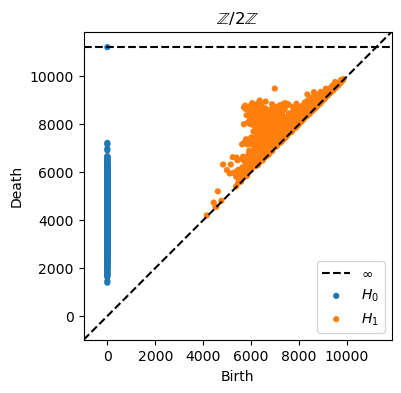

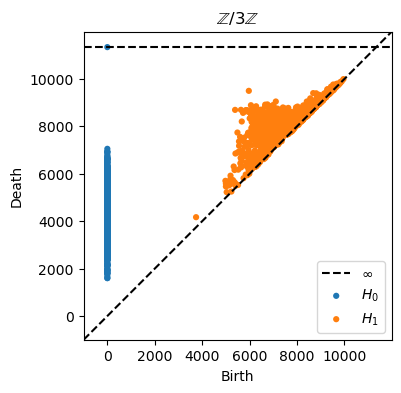

In [18]:
persistent_homology(blurred_image, 50, 1000, 2)
persistent_homology(blurred_image, 50, 1000, 3)

Even with the blurring, we still just get noise and a very weak signal.

### Point Group: $C_1$

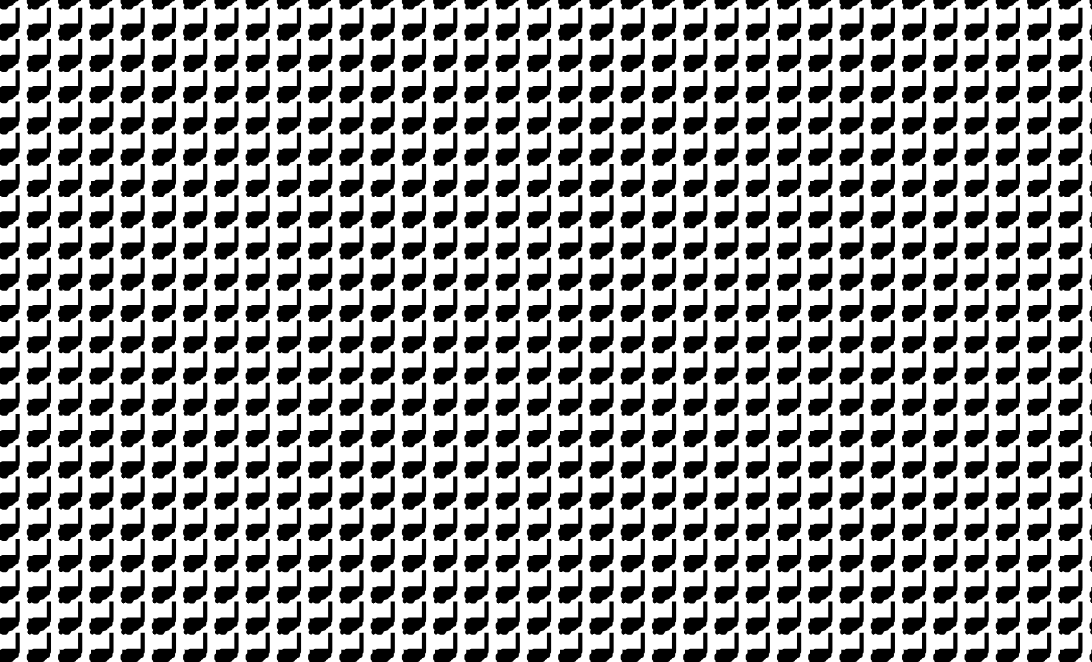

In [19]:
# Grab image from files
img_names = glob.glob('images/*C1music.png')
img = Image.open(img_names[0])
display(img)

Without blurring:

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[1800.94921875, 1740.4833984375, 1670.0400390625, 1663.43994140625, 1638.4970703125, 1535.9033203125, 1535.57470703125]


/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[1764.31640625, 1747.94921875, 1745.4384765625, 1721.001953125, 1649.9091796875, 1617.5654296875, 1614.4208984375]


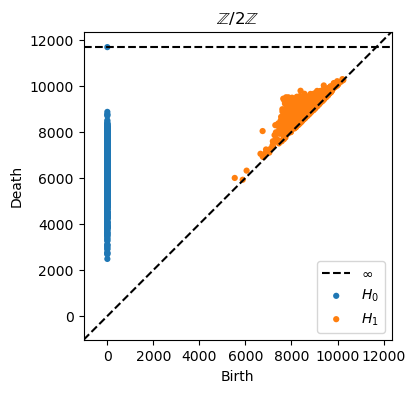

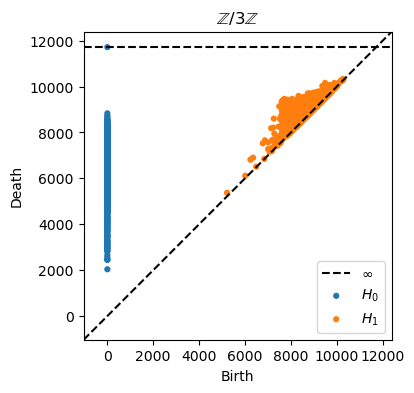

In [20]:
persistent_homology(img, 40, 1000, 2)
persistent_homology(img, 40, 1000, 3)

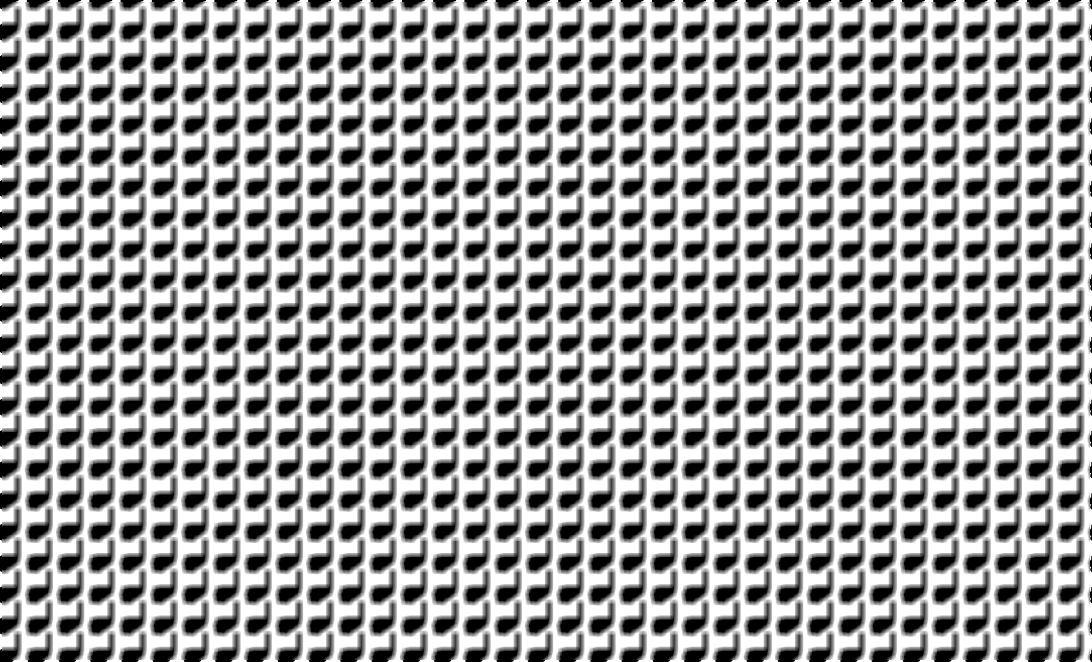

In [21]:
blurred_image = img.filter(ImageFilter.BLUR)
display(blurred_image)

Now with blurring:

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[2146.99658203125, 1828.6220703125, 1777.59326171875, 1771.5185546875, 1740.724609375, 1721.1318359375, 1696.77490234375]


/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


largest 7 lengths of H1 intervals
[1889.84423828125, 1837.048828125, 1820.759765625, 1806.6220703125, 1797.5673828125, 1714.95849609375, 1713.46240234375]


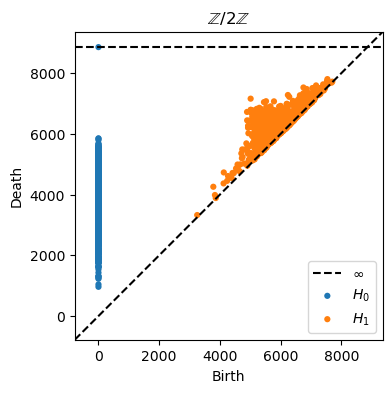

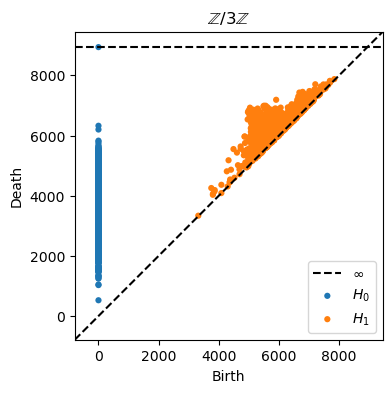

In [22]:
persistent_homology(blurred_image, 40, 1000, 2)
persistent_homology(blurred_image, 40, 1000, 3)

Even with blurring, we still just get noise. In general, $C_4$ and $C_6$ are the groups that usually get clear and correct signals, and the blurring seems to further clear the signal for them. However, we generally do not get good results for $C_1$ $C_2$ and $C_3$, and the blurring does not make a valuable difference in these cases. 

## Effects of Softmax Embedding

Let $x\in \mathbb{R}^K$ be a vector that represents the pixel colorings of an image. The softmax functions maps $x$ to $\sigma(x) \in (0,1)\subset \mathbb{R}^K$ where the $i^{th}$ component of $\sigma(x)$ is 

$$ \frac{e^{x_i}}{\sum_{j=1}^Ke^{x_j}}$$

Note that the sum of the components of $\sigma(x)$ is 1, and when applied to an image only the brightest parts will be highlighted.

We test this softmax embedding on functions that define wallpaper tilings on $\mathbb{R}^2$.

In [23]:
def view_window_continuous(image_function, num_pixels, window_size):
    
    pixels = get_pixels(num_pixels, window_size)
            
    x_points = []
    y_points = []
    colors = []
    for i in range(len(pixels)):
        color = image_function(pixels[i][0],pixels[i][1]) 
        colors.append(color)
        x_points.append(pixels[i][0])
        y_points.append(pixels[i][1])
    
    fig = plt.figure(figsize = (7, 7))
    ax = plt.axes()
    ax.scatter(x_points, y_points, c = colors)
    plt.show()
    
    
def get_pixels(num_pixels, window_size):
    sample = list(np.linspace(-window_size/2, window_size/2, num_pixels))
    pixels = []
    for i in range(len(sample)):
        for j in range(len(sample)):
            pixels.append((sample[i],sample[j]))     
    return pixels


def get_colors(pixels, image_function):
    colors = []
    for pixel in pixels:
        colors.append(image_function(pixel[0],pixel[1]))
    return colors  

def translation(a,b):
    def t_ab(x,y): 
        return x+a, y+b
    return t_ab

def rotation(theta):
    def r_theta(x,y):
        return x * cos(theta) - y * sin(theta), x * sin(theta) + y * cos(theta)
    return r_theta

def isom(a,b,theta):
    def iso(x,y):
        r = rotation(theta)
        t = translation(a,b)
        return t(r(x,y)[0], r(x,y)[1])
    return iso

def generate_isom(n_isos, x_translate, y_translate):
    a = list(2 * x_translate * np.random.random(n_isos) - x_translate) # sampling from (-x,x)
    b = list(2 * y_translate * np.random.random(n_isos) - y_translate) # sampling from (-y,y)
    theta = list(2 * pi * np.random.random(n_isos)) # sampling from (0, 2pi)

    isos = []
    isos_inv = []
    for i in range(n_isos):
        isos.append(isom(a[i], b[i], theta[i]))
        isos_inv.append(isom(-1 * a[i],-1 * b[i],2 * pi - theta[i])) 
    return isos_inv

def new_colors(pixels, iso_inv, image_function):
    pixels_inv = []
    for pixel in pixels: 
        pixels_inv.append(iso_inv(pixel[0], pixel[1]))
    new_colors = get_colors(pixels_inv, image_function)
    return new_colors

def matrix_of_images(pixels, isos_inv, image_function):
    vectors = []
    for i in isos_inv:
        vectors.append([new_colors(pixels, i, image_function)])
    M = np.concatenate(vectors, axis=0 )
    return M

def p_hom(M, maxdim, coeff):
    output = ripser(M, maxdim = maxdim, coeff = coeff)
    return output
    
def persistent_H1_intervals(output):
    H1 = output['dgms'][1].tolist() # all intervals in H1
    d = []
    for pair in H1: 
        d.append(pair[1] - pair[0]) # finding lengths of intervals in H1
    d.sort(reverse = True) # sorting from longest to shortest intervals
    return d[:10]

def plot_dgms(output):
    dgms = output['dgms']
    fig = plt.figure(figsize = (12, 6))
    plot_diagrams(dgms)
    
def pipeline(image_function, num_pixels, window_size, n_isos, x_translate, y_translate, maxdim, coeff):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom(n_isos, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    output = p_hom(M, maxdim, coeff)
    return output


We define a variant of softmax that makes bright pixels brighter *and* dark pixels darker

In [24]:
def softmax_variant(vector):
    sum_exp = 0
    for x in vector:
        sum_exp = sum_exp + exp(abs(x))
    for i in range(len(vector)):
        if vector[i] >= 0:
            vector[i] = exp(vector[i])/sum_exp
        else: 
            vector[i] = - exp(abs(vector[i]))/sum_exp
    return vector

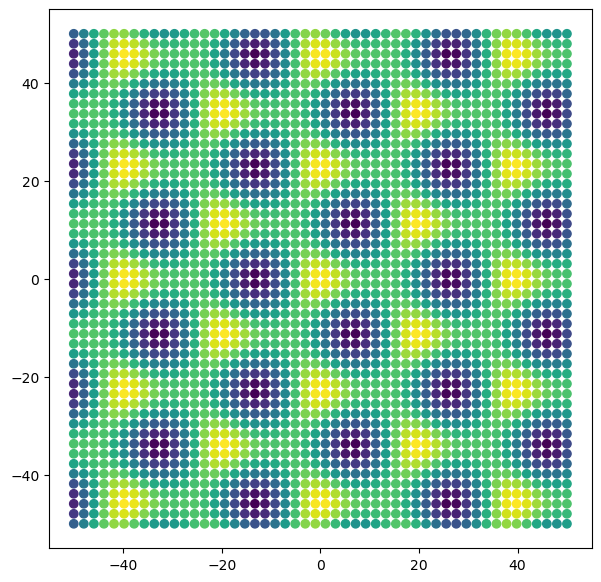

In [25]:
def c3(x,y):
    X = 1/(2 * pi) * (x + y / (3**(1/2)))
    Y = 1/(2 * pi) * 2 * y / (3**(1/2))
    C = cos(X + Y) + cos(X - 2 * Y) + cos(-2 * X + Y)
    S = sin(X + Y) +sin(X - 2*Y) +sin(-2 * X + Y)
    return C + S

view_window_continuous(c3, 50,100)

Let's look at our image after performing the softmax variant

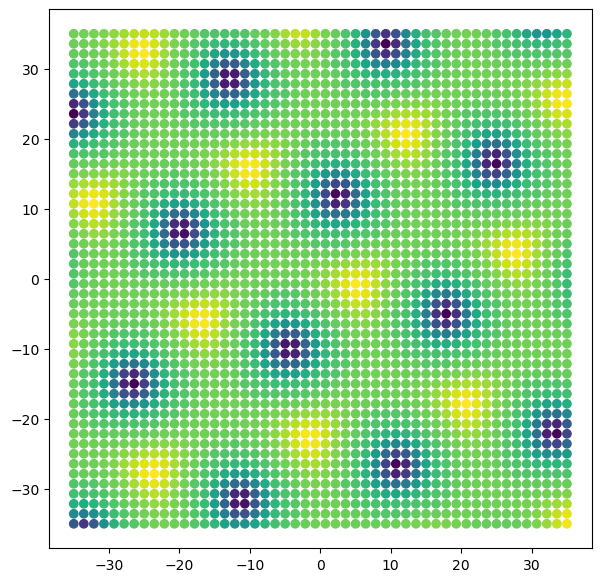

In [26]:
pixels = get_pixels(num_pixels=50, window_size=70)
isos_inv = generate_isom(n_isos=10, x_translate=200, y_translate=200)
colors = []
for i in isos_inv:
    colors.append(softmax_variant(new_colors(pixels = pixels, iso_inv = i, image_function = c3)))
    
x_points = []
y_points = []
for i in range(len(pixels)):
    x_points.append(pixels[i][0])
    y_points.append(pixels[i][1])
    
fig = plt.figure(figsize = (7, 7))
ax = plt.axes()
ax.scatter(x_points, y_points, c = colors[0])
plt.show()

Softmax seems to get rid of image features that aren't as important, making the $C_3$ symmetry more obvious.

In [27]:
def matrix_of_images_softmax(pixels, isos_inv, image_function):
    vectors = []
    for i in isos_inv:
        vectors.append([softmax_variant(new_colors(pixels, i, image_function))])
    M = np.concatenate(vectors, axis=0 )
    return M

def pipeline_softmax(image_function, num_pixels, window_size, n_isos, x_translate, y_translate, maxdim, coeff):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom(n_isos, x_translate, y_translate)
    M = matrix_of_images_softmax(pixels, isos_inv, image_function)
    output = p_hom(M, maxdim, coeff)
    return output

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


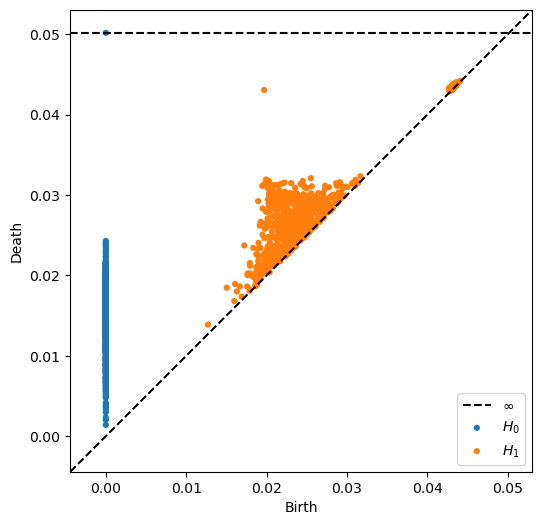

In [28]:
output = pipeline_softmax(image_function=c3, num_pixels = 50, window_size = 50, n_isos=1000, x_translate=200, y_translate=200, maxdim=1, coeff=2)
plot_dgms(output)

In [29]:
persistent_H1_intervals(output)

[0.02335124835371971,
 0.012003228068351746,
 0.011674771085381508,
 0.011656120419502258,
 0.011446923017501831,
 0.01139366440474987,
 0.01128373108804226,
 0.010698314756155014,
 0.010464513674378395,
 0.010352833196520805]

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


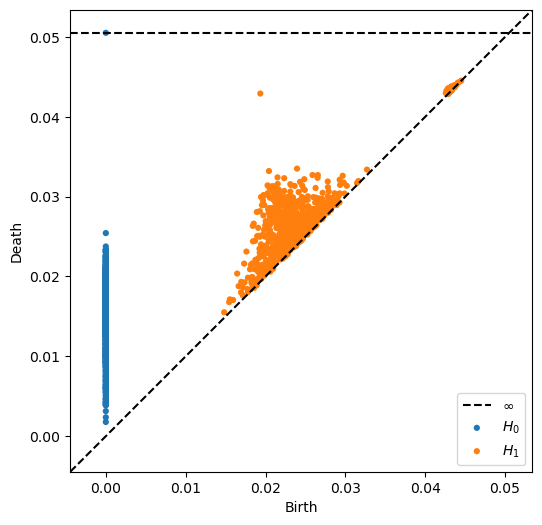

In [30]:
output = pipeline_softmax(image_function=c3, num_pixels = 50, window_size = 50, n_isos=1000, x_translate=200, y_translate=200, maxdim=1, coeff=3)
plot_dgms(output)

In [31]:
persistent_H1_intervals(output)

[0.023558175191283226,
 0.012773044407367706,
 0.011147132143378258,
 0.010905830189585686,
 0.010574845597147942,
 0.0105142742395401,
 0.01049833558499813,
 0.010428555309772491,
 0.010384049266576767,
 0.010247103869915009]

Unfortunately, the persistent homology calculation remains the same as found in 4_phom_identification, which was incorrect and seemed to be mistaking the $C_3$ for $C_6$.

## Effects of Hilbert Embedding 

The problem we seem to be having with the $C_3$ image function pictured below is a "hallucination" of rotational symmetries that would exist in the $C_6$ case, but not $C_3$. 

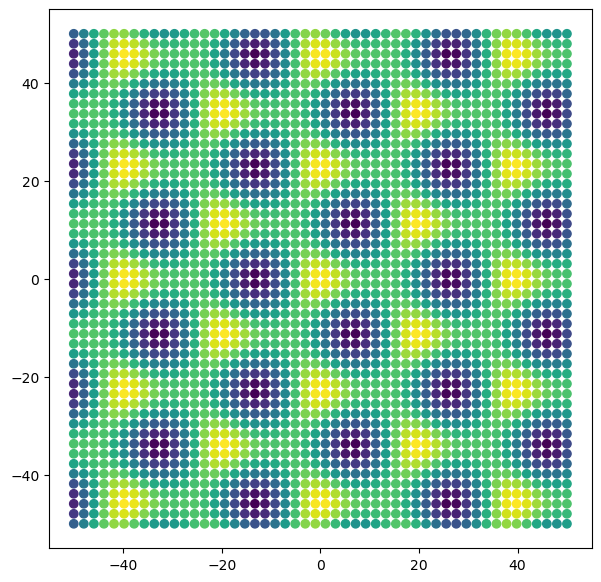

In [32]:
view_window_continuous(c3, 50,100)

To investigate this problem, we consider the distance matrix below. This matrix encodes the pairwise Euclidean distances between a series of 100 images. These images are generated from a lens applied to 100 different rotational isometries of the cartesian plane. In particular, each isometry is a rotation around the vertical line though the point $(27,23.5,0)$, which is roughly at the center of one of the purple blobs in the $C_3$ image, and the rotations are sampled incrementally between $0$ and $2\pi$.

In [37]:
def compose_isoms(i1,i2, i3):
    def comp(x,y):
        x2 = i1(x,y)[0]
        y2 = i1(x,y)[1]
        x3 = i2(x2,y2)[0]
        y3 = i2(x2,y2)[1]
        return i3(x3,y3)
    return comp

def view_dist_matrix(image_function, distance_function, num_pixels, window_size, n_isos, title):
    
    isoms = []
    for i in range(n_isos):
        theta = (2*pi)/(n_isos-1) * i 
        isom1 = isom(-27,-23.5,0)
        isom2 = isom(0,0,theta)
        isom3 = isom(27,23.5,0)
        f = compose_isoms(isom1,isom2,isom3)
        isoms.append(f)
    
    pixel_colorings = []
    for f in isoms:
        pixels = get_pixels(num_pixels, window_size)
        point = new_colors(pixels, iso_inv=f, image_function=image_function)
        pixel_colorings.append(point)
    
    x = range(n_isos)
    y = range(n_isos)
    
    x_points = []
    y_points = [] 
    
    for i in x:
        for j in y:
            x_points.append(i)
            y_points.append(j)
            
    M = np.zeros((n_isos,n_isos))
    for i in range(n_isos):
        for j in range(n_isos):
            M[i][j] = distance_function(pixel_colorings[i], pixel_colorings[j])

    
    fig = plt.figure(figsize = (7, 7))
    ax = plt.axes()
    plt.title(title)
    plt.xlabel('indexed images')
    plt.ylabel('indexed images') 
    scatter = ax.scatter(x_points, y_points, c = np.concatenate(M),cmap='viridis')
    plt.legend(*scatter.legend_elements())
    plt.show()

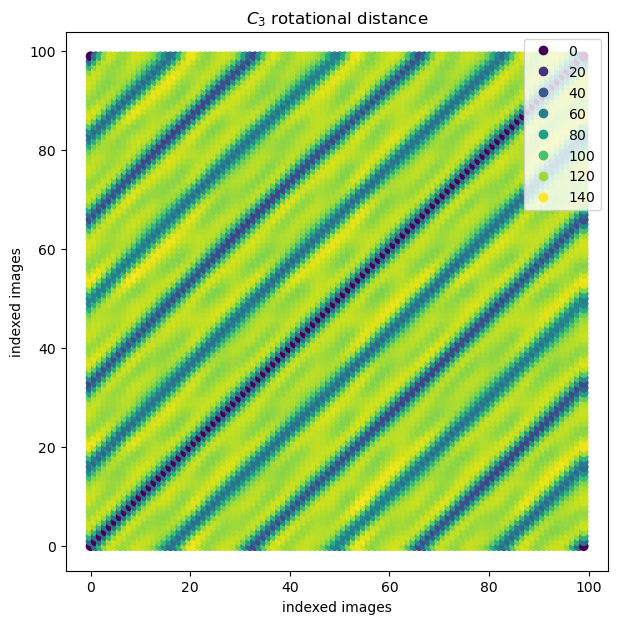

In [38]:
view_dist_matrix(image_function=c3, distance_function=dist, num_pixels = 50, window_size = 50, n_isos=100, title='$C_3$ rotational distance')

The five blue lines above and below the main diagonal in the distance matrix indicate that two images that differ by a $\pi/3$ rotation in their corresponding isometries have a small distance between them. Since this is a $C_3$ image, we would want this to be the case for $2\pi/3$ rotational differences only. Thus the way we have embedded these $C_3$ lens images results in a "hallucination" of rotational symmetry by $\pi/3$, $\pi$, and $5\pi/3$ around $(27,23.5)$. It seems likely that the problem is that if we rotate by $\pi/3$ around $(27,23.5)$, only the yellow blobs are misaligned between the two images, so the coloring of the images are still similar. A possible fix would be to artifically increase the distance between images when they are found to be close but have "chuncks" of pixels that are misaligned. This would require some notion of relative location of pixels in the image. We will use a Hilbert curve to try to create this locality.

In [39]:
from hilbertcurve.hilbertcurve import HilbertCurve

The Hilbert curve is a continuous, space-filling curve that covers every box in a grid (see the picture below). Up to this point, we have ordered the pixels of a lens starting in the bottom left corner and progressing across one row at a time. We can choose any ordering on the pixels and as long as we are consistent across all images, the distance between images should remain the same. 

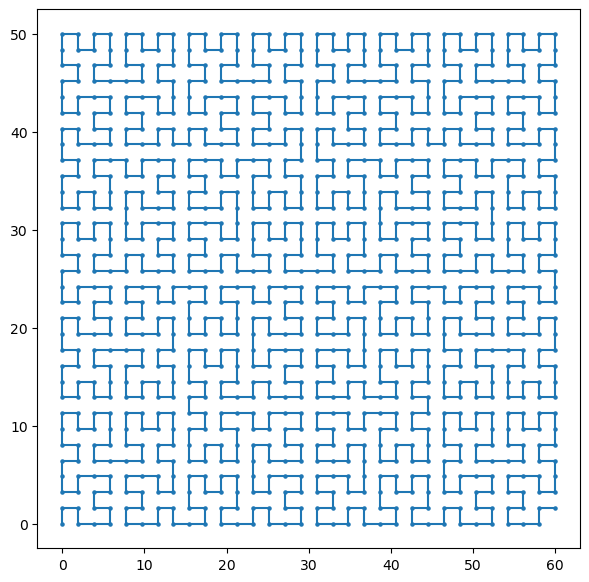

In [40]:
def get_hilbert_pixels(p, x_size, y_size):
    distances = list(range(2**(2*p)-1))
    pixels = HilbertCurve(p,2).points_from_distances(distances)
    for i in range(len(pixels)):
        pixels[i][0] = x_size * pixels[i][0]/ 31
        pixels[i][1] = y_size * pixels[i][1]/ 31
    return pixels

def view_hilbert(p, x_size, y_size):
    
    points = get_hilbert_pixels(p, x_size, y_size)

    x_points = []
    y_points = []
    for i in range(len(points)):
        x_points.append(points[i][0])
        y_points.append(points[i][1])  

    fig = plt.figure(figsize = (7, 7))
    plt.scatter(x_points,y_points, s = 5)
    plt.plot(x_points, y_points)
    plt.show()
    
view_hilbert(5, 60, 50)

As shown below, if we order the pixels along the Hilbert curve, we get the same problematic distance matrix as before.

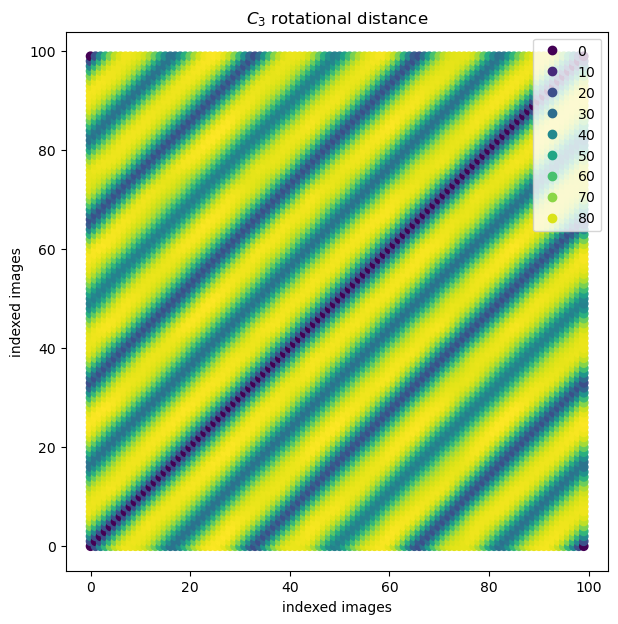

In [43]:
def view_dist_matrix(image_function, distance_function, p, x_size, y_size, n_isos, title):
    
    isoms = []
    for i in range(n_isos):
        theta = (2*pi)/(n_isos-1) * i 
        isom1 = isom(-27,-23.5,0)
        isom2 = isom(0,0,theta)
        isom3 = isom(27,23.5,0)
        f = compose_isoms(isom1,isom2,isom3)
        isoms.append(f)
    
    pixel_colorings = []
    for f in isoms:
        pixels = get_hilbert_pixels(p=p, x_size = x_size, y_size= y_size)
        point = new_colors(pixels, iso_inv=f, image_function=image_function)
        pixel_colorings.append(point)
    
    x = range(n_isos)
    y = range(n_isos)
    
    x_points = []
    y_points = [] 
    
    for i in x:
        for j in y:
            x_points.append(i)
            y_points.append(j)
            
    M = np.zeros((n_isos,n_isos))
    for i in range(n_isos):
        for j in range(n_isos):
            M[i][j] = distance_function(pixel_colorings[i], pixel_colorings[j])

    
    fig = plt.figure(figsize = (7, 7))
    ax = plt.axes()
    plt.title(title)
    plt.xlabel('indexed images')
    plt.ylabel('indexed images') 
    scatter = ax.scatter(x_points, y_points, c = np.concatenate(M),cmap='viridis')
    plt.legend(*scatter.legend_elements())
    plt.show()
    
view_dist_matrix(image_function=c3, distance_function=dist, p=5, x_size=60, y_size=60, n_isos=100, title='$C_3$ rotational distance')

Another way to view these rotational hallucinations is to plot the different between the original image and images under rotation around the vertical line through $(27,23.5,0)$. The image below indicates that the original image is better approximated by rotations by $2\pi/3$ than $\pi/3$, but the distance between the orignal image and the image under rotation by $\pi/3$ is still small.

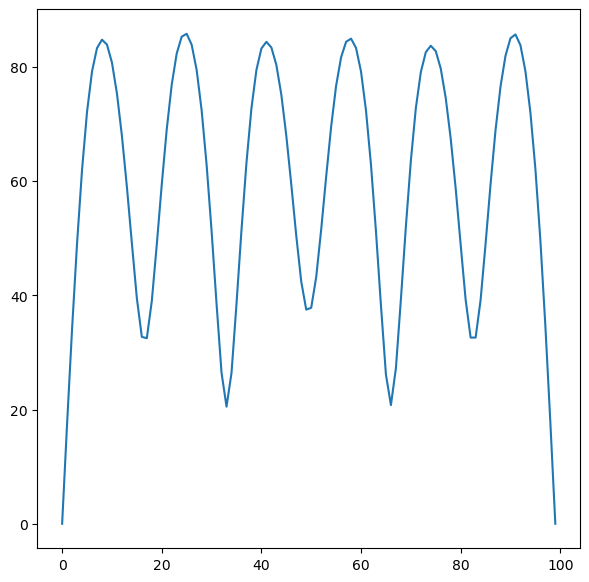

In [44]:
n_isos = 100
x_size = 60
y_size = 50 
image_function = c3
p=5

isoms = []
for i in range(n_isos):
    theta = (2*pi)/(n_isos-1) * i 
    isom1 = isom(-27,-23.5,0)
    isom2 = isom(0,0,theta)
    isom3 = isom(27,23.5,0)
    f = compose_isoms(isom1,isom2,isom3)
    isoms.append(f)
    
pixel_colorings = []
for f in isoms:
    pixels = get_hilbert_pixels(p=p, x_size = x_size, y_size= y_size)
    point = new_colors(pixels, iso_inv=f, image_function=image_function)
    pixel_colorings.append(point)
    
colors1 = pixel_colorings[0]
distance_list = []

for i in range(len(pixel_colorings)):
    distance_list.append(dist(colors1, pixel_colorings[i]))
    
    
x = range(100)
fig = plt.figure(figsize = (7, 7))
plt.plot(x, distance_list)
plt.show()

Since the Hilbert curve pixelation preserves some sense locality, we can try to penalize when two similar images have a collection of nearby pixels that differ between the images. The following chunk function counts how many times there are $n$ consecutive pixels that differ in color between two images, for some $n\in \mathbb{Z}$. 

In [45]:
def chunk(colors1, colors2, chunk_length=10):
    difference = []
    for i in range(len(colors1)):
        difference.append(colors1[i]-colors2[i])
            
    j = 0 
    chunks = 0 

    count = 0
    while j < len(difference):
        count = 0
        while j < len(difference) and abs(difference[j])>1:
            count += 1
            j += 1
        if j < len(difference) and abs(difference[j])<=1 and count >= chunk_length:
            chunks += 1
            j += 1
        else:
            j += 1
        
    return chunks

We can make a similar plot to that above that compares the original image to a series of rotation, this time using the chunk function as a proxy for distance between images.

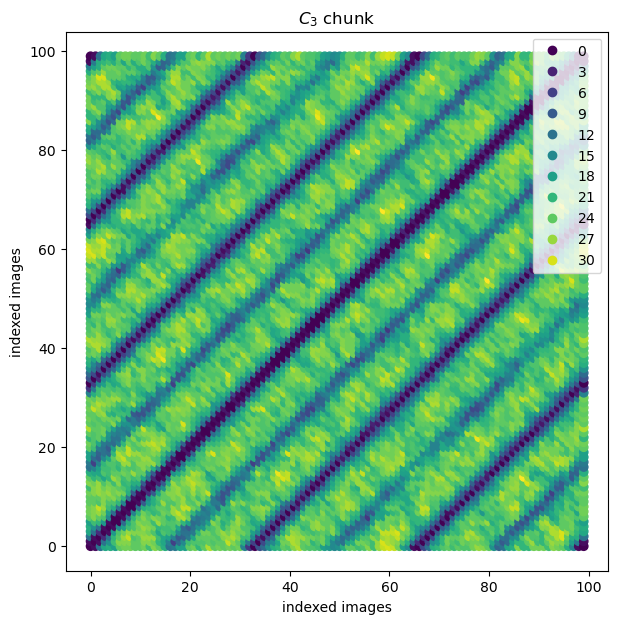

In [47]:
view_dist_matrix(image_function=c3, distance_function=chunk, p=5, x_size=60, y_size=60, n_isos=100, title='$C_3$ chunk')

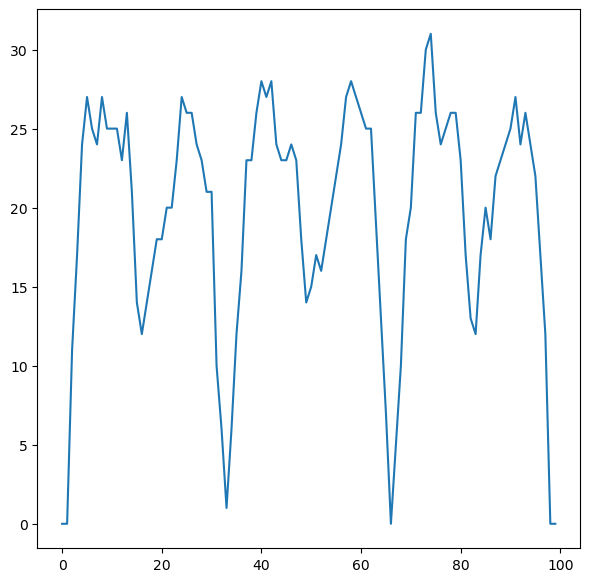

In [48]:
chunk_list = []

for i in range(len(pixel_colorings)):
    chunk_list.append(chunk(colors1, pixel_colorings[i]))

x = range(100)
fig = plt.figure(figsize = (7, 7))
plt.plot(x, chunk_list)
plt.show()

The chunk function doesnt give still shows a smaller distance between images whose isometries are $\pi/3$ apart, but it is less so than the regular Euclidean distance function. We can test how helpful it is by trying persistnet homology

In [49]:
def dist_matrix_pipeline(image_function, distance_function, p, x_size, y_size, n_isos, x_translate, y_translate):
    
    pixels = get_hilbert_pixels(p, x_size,y_size)
    isos_inv = generate_isom(n_isos, x_translate, y_translate)
    
    colors = []
    for i in isos_inv:
        colors.append(new_colors(pixels, i, image_function))
            
    M = np.zeros((n_isos,n_isos))
    for i in range(n_isos):
        for j in range(n_isos):
            M[i][j] = distance_function(colors[i], colors[j])
    
    return M

In [50]:
M = dist_matrix_pipeline(image_function=c3, distance_function=chunk, p=5, x_size=60, y_size=50, n_isos=1000, x_translate=1000, y_translate=1000)

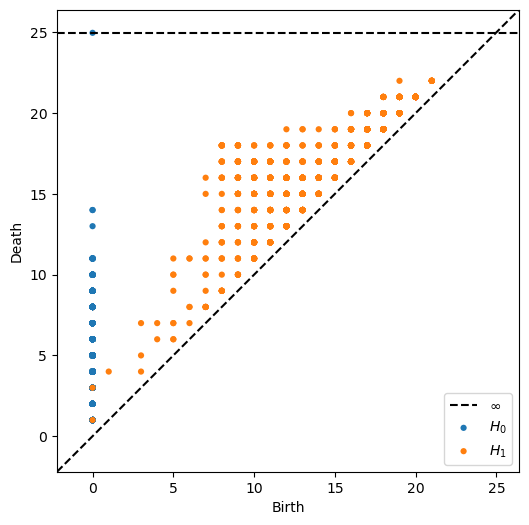

In [51]:
output = ripser(M, maxdim=1, coeff=2, distance_matrix=True)
plot_dgms(output)

This doesn't look great... let's try something more continuous

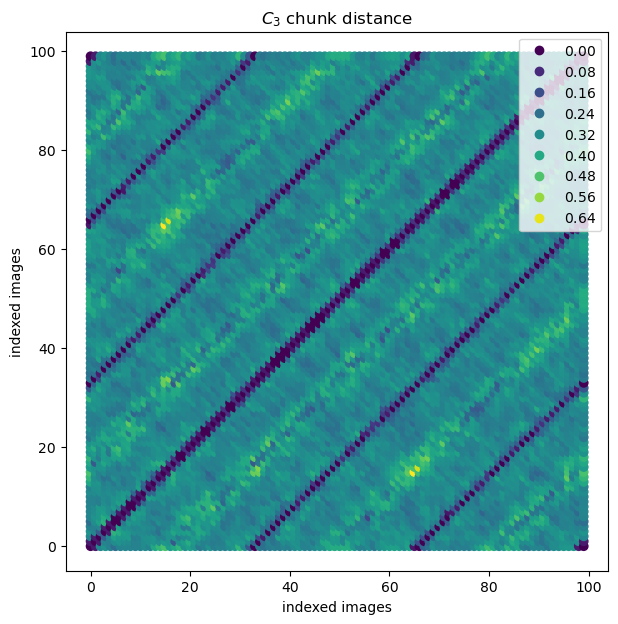

In [53]:
def distance_chunk(colors1, colors2):
    if dist(colors1,colors2)>0:
        return chunk(colors1,colors2,10) * 1/dist(colors1,colors2)
    else:
        return 0
    
view_dist_matrix(image_function=c3, distance_function=distance_chunk, p=5, x_size=60, y_size=60, n_isos=100, title='$C_3$ chunk distance')

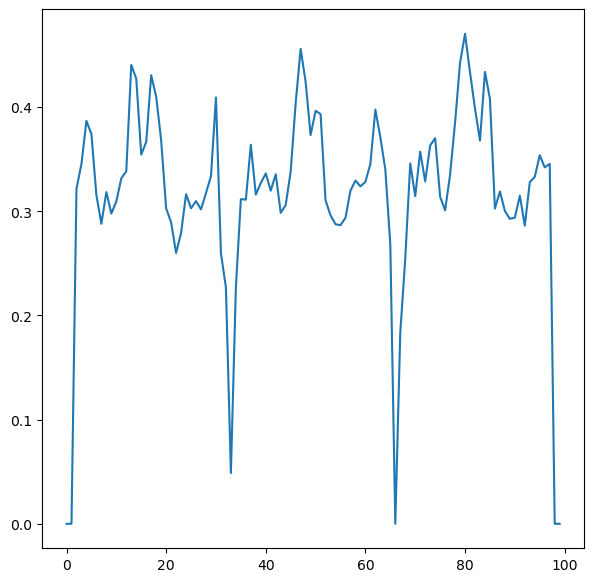

In [54]:
chunk_list = []

for i in range(len(pixel_colorings)):
    chunk_list.append(distance_chunk(colors1, pixel_colorings[i]))

x = range(100)
fig = plt.figure(figsize = (7, 7))
plt.plot(x, chunk_list)
plt.show()

Again, not the ideal distance function, but the general shape is getting closer to being trimodal like we want it to be.

In [55]:
M = dist_matrix_pipeline(image_function=c3, distance_function=distance_chunk, p=5, x_size=60, y_size=50, n_isos=1000, x_translate=1000, y_translate=1000)

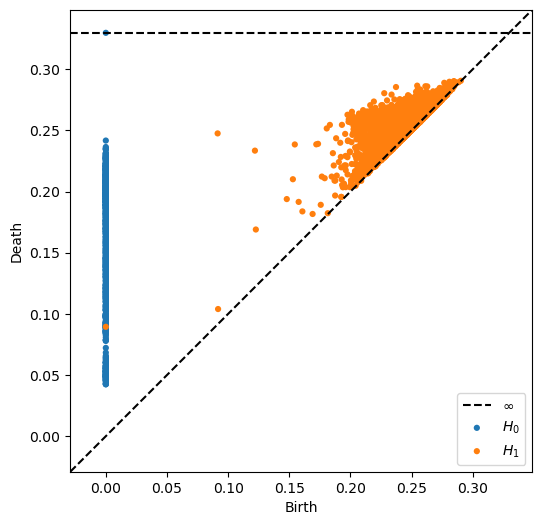

In [56]:
output = ripser(M, maxdim=1, coeff=2, distance_matrix=True)
plot_dgms(output)

Still just getting a bunch of noise. 

## Effects of Metric Choice

### Manhattan Distance

By default, Ripser computes the distance between samples using the Euclidean distance. Our samples are vectors from a vector space of dimension $h \cdot w$ where $h$ and 
$w$ are the height and width of the lens. This presents two problems: first, the large dimension makes the distances difficult to understand intuitively, and obscures the way an embedding affects the distances between images. Second, only a pixel's color value is considered, not its position; this means that information is lost in the distance calcuation. Note that we assume lens size is consistent, so our metrics always compare images of the same height and width.

One strategy to solve the first issue is by using a metric that better suited for high dimensionality. We will try the manhattan distance $d(x,y) = \Sigma | x - y|$, where x and y are 2 vectors.

In [57]:
img_names = glob.glob('../studentDemos/images/*C4pinwheel.png')
img = Image.open(img_names[0])
img = img.convert('L')
persistent_homology(img, 40, 1000, 2, metric = "manhattan")
temp = persistent_homology(img, 40, 1000, 2, metric = "euclidean")

TypeError: persistent_homology() got an unexpected keyword argument 'metric'

The manhattan didn't improve the signal significantly, so lets try again with the blurred version of this image.

In [ ]:
blurred_image = img.filter(ImageFilter.BLUR)
manhat = persistent_homology(blurred_image, 40, 1000, 2, metric = "manhattan")
euclid = persistent_homology(blurred_image, 40, 1000, 2, metric = "euclidean")

Again, the signal strength seems to be similar. If we compare the relative distance between the least persistent outlier and the most persistent noise for both metrics, we find them to be similiar:

In [ ]:
print("relative distance for manhattan metric: " + str((manhat[1][1]) / manhat[1][2])) 
print("relative distance for Euclidean metric: " + str((euclid[1][1]) / euclid[1][2])) 

While the signal strength is not improved, the change in metric does make these distances more quantifiable. Because we are working with grayscale images, every pixel is an integer value represnting saturation between 0 and 255. With the manhattan metric, this means that an image with a distance of 255 from another is 255 color values different; it may have one pixel be black instead of white, it may have 255 pixels with one less saturation, or any other combination of pixel differences that sum to 255. We can approximate the pixel difference by dividing a manhattan distance by 255; if two images have a distance of 2550, then they would have at least 10 pixels with different values.
If we observe the most persistent point in our manhattan metric diagram, we can divide its birth and death times by 255 to approximate these times as pixel differences:

In [ ]:
pairs = []
for pair in manhat[0]['dgms'][1]: 
    pairs.append((pair[1] - pair[0], pair)) # finding lengths of intervals in H1
pairs = sorted(pairs, key=lambda x: x[0], reverse = True) # sort based on interval length
print("birth pixel distance: "  + str(pairs[0][1][0] / 255))
print("death pixel distance: "  + str(pairs[0][1][1] / 255))

One hypothesis we could draw from this current observation is that with a lense size of 40, this cycle was born from $\frac{215}{40} \approx 5$ 1 pixel translations and dies at about $\frac{448}{40} \approx 11$ 1 pixel translations. We assume translations are in the cardinal directions, so we might expect about 40 pixels to change color values with each translation. Cardinal translations don't match the sampling of isometries, but nevertheless lets us easily approximate these findings. Additionally, even if 40 pixels are different due to the translation, it is unlikey that there is a color difference of $40 \cdot 255 = 10200$, so this hypothesis needs much improvement; the point is that this hypothesis only makes sense when using the manhattan distance.

### Hausdorff Distance

In order to utilize the positions of pixels in distance calculation, we will have to make our images monochromatic and regard the black pixels as points in a grid. This means our images will become matrices of up to $h \cdot w$ 2d points rather than an element of a $h \cdot w$ dimensional vector space. Now we can calculate the Hausdorff distance, which utilizes the distance between points: \
"Given two finite point sets $A =\{ a_1,..., a_p\}$ and $B = \{ b_1,...,b_q\}$, the Hausdorff distance is defined as
\\[ H(A,B) = \max \left(h(A,B),h(B,A)\right) \\]
where \
\\[ h(A,B) = \max_{a \in A} \min_{b \in B} || a - b||\\]
and $|| \cdot ||$ is some underlying norm on the points of A and B (e.g., the $L_2$ or Euclidean norm)." [1] \
We will use the py-hausdorff library with the euclidean norm (https://github.com/mavillan/py-hausdorff#py-hausdorff) for this calculation, which implements the algorithm from [2].

In [ ]:
from hausdorff import hausdorff_distance

# Functions

def get_pixel_isom_haus(isoms, img, lens):
    # here we take snapshots using the given isometries.
    isom_images = []
    for iso in isoms:
        isom_images.append(create_snapshot(img, lens, iso))
    ret_lst = []
    for elem in isom_images:
        # here we theshold the image at half saturation,
        # then make it monochromatic.
        elem = elem.point( lambda p: 255 if p > 127 else 0 )
        elem = elem.convert('1')
        data = np.asarray(elem)
        arr = []
        # for each black pixel, we store its index as a 2d point.
        for x in range(data.shape[0]):
            for y in range(data.shape[1]):
                if data[x][y] == 1:
                    arr.append(np.array([x,y]))
        arr = np.asarray(arr)
        ret_lst.append(arr)
    return ret_lst

Because the Hausdorff metric compares distances between sets rather than points, our previous pipeline won't work. We also cannot plug the metric directly into ripser, because ripser also compares points rather than sets. Instead, we compute the distance matrix and feed it into ripser. To make this efficent, we do not compute symmetric distances twice, nor do we compute reflexive distances.

In [ ]:
lens_sz = 40
n_samples = 1000
isoms = generate_isoms(img, lens_sz, n_samples)
data = get_pixel_isom_haus(isoms, img, lens_sz)

# generate distance matrix:
# note that the hausdorff distance takes much 
# longer to compute than other distances.
march = np.zeros((n_samples,n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        if i < j:
            march[i][j] = hausdorff_distance(data[i], data[j])
# set the lower triangle values to their symmetric counterparts
# note the reflexive values were already initialized to 0
for i in range(n_samples):
    for j in range(n_samples):
        if i > j:
            march[i][j] = march[j][i]
            
# this figure shows the distance matrix appears as expected;
# symmetrical across the diagonal with zero values on the diagonal.
plt.figure()
plt.imshow(march)
plt.show()

In [ ]:
res = ripser(march, maxdim=1,  coeff =2, distance_matrix = True)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plt.title("$\mathbb{Z} /$"+str(2)+"$\mathbb{Z}$")
plot_diagrams(dgms)

In [ ]:
 H1 = res['dgms'][1].tolist() # all intervals in H1
d = []
for pair in H1: 
    d.append(pair[1] - pair[0]) # finding lengths of intervals in H1
d.sort(reverse = True) # sorting from longest to shortest intervals
print("largest 7 lengths of H1 intervals")
print(d[:7])

Unfortunately, the results are dissapointing. There are no clear outliers, and nearly all 1 dimensional cycles are dying before all of the 0 dimensional cycles have died. Additionally, the running time is much longer (this distance matrix took about 30 minutes to compute), and we cannot use the blurring technique because the snapshots are monochromatic. One improvement to this method is to use edge detection like in [1]; by only looking at the edges of the image, we may speed up the computation and get better results. We will use the Canny edge dectection algorithm offered by OpenCV.

In [ ]:
import cv2 as cv
imgCV = cv.imread(img_names[0], cv.IMREAD_GRAYSCALE)

edges = cv.Canny(imgCV,100,200)
# By default, edges found by this function are white pixels;
# we need them to be black so we can store the edge pixels as points
edges = cv.bitwise_not(edges)
plt.subplot(121),plt.imshow(imgCV,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
# convert the image to Pillow type
temp = np.asarray(edges)
edges = Image.fromarray(temp)
edges

In [ ]:
isoms = generate_isoms(edges, lens_sz, n_samples)
data = get_pixel_isom_haus(isoms, edges, lens_sz)

march2 = np.zeros((n_samples,n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        if i < j:
            march2[i][j] = hausdorff_distance(data[i], data[j])
for i in range(n_samples):
    for j in range(n_samples):
        if i > j:
            march2[i][j] = march2[j][i]

In [ ]:
res = ripser(march2, maxdim=1,  coeff =2, distance_matrix = True)
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plt.title("$\mathbb{Z} /$"+str(2)+"$\mathbb{Z}$")
plot_diagrams(dgms)

In [ ]:
H1 = res['dgms'][1].tolist() # all intervals in H0
d = []
for pair in H1: 
    # finding lengths of intervals in H1
    d.append((pair[1] - pair[0], pair)) 
sorted(d, reverse = True, key=lambda x: x[0])
print("length of the " + str(len(d)) + " H1 intervals")  
for i in d:
    print(i[0])
print("birth and death of the " + str(len(d)) + " H1 intervals")  
for i in d:
    print(i[1])



In [ ]:
H0 = res['dgms'][0].tolist() # all intervals in H0
d = []
for pair in H0: 
    # finding lengths of intervals in H0
    d.append((pair[1] - pair[0], pair)) 
sorted(d, key=lambda x: x[0])
print("length of the 5 most persistent H0 intervals")  
for i in d[-1:-5:-1]:
    print(i[0])
print("birth and death of 5 most persistent H0 intervals")  
for i in d[-1:-5:-1]:
    print(i[1])


This time the homology only finds 4 cycles with the exact same birth, death, and lifetime; these cycles also die when the last finite H0 cycle dies. While the lack of noise is promising, if we regard these 4 cycles as outliers then we get the wrong homology dimension. Running time was even worse, being left overnight to compute; it is possible that this is python's fault and not that Hausdorff takes longer to compute on edges. One further experiment with this metric might include observing the elements of the H1 cycles, to see what the metric is considering a cycle. Other experiments include using a different isometry distribution and using the Hausdorff quantile distance as mentioned in [2], to reduce the effect of outliers on the distance.

References: \
[1] D. P. Huttenlocher, G. A. Klanderman and W. J. Rucklidge, "Comparing images using the Hausdorff distance," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 15, no. 9, pp. 850-863, Sept. 1993, doi: 10.1109/34.232073.\
[2]  A. A. Taha and A. Hanbury, "An Efficient Algorithm for Calculating the Exact Hausdorff Distance," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 37, no. 11, pp. 2153-2163, 1 Nov. 2015, doi: 10.1109/TPAMI.2015.2408351.\